# In this worksheet, we'll start building a framework to EVOLVE BRAINS!

In [6]:
import numpy as np

#let's ignore overflow warnings from numpy in case we get
#big numbers, no biggy.
np.seterr(over='ignore', divide='raise')

import random
from IPython.display import clear_output, display

from matplotlib import pyplot

## We can make a generic neural network class that builds a random network with a specified number of inputs and outputs (and hidden nodes, but we'll get to that later!)

 This code takes care of randomly generating weights for each edge in our neural net

In [7]:
class SimpleNeuralNet():
    #this is our squashing function
    def activation_function(self, x):
        return 1/(1+np.exp(-x))
    
    #this should look familiar, just a way to create a copy of 
    #the network without worying about pesky reference 
    def deepcopy(self):
        new_net = SimpleNeuralNet(self.num_inputs, self.num_outputs, self.layer_node_counts)
        new_net.layers = [np.copy(layer) for layer in self.layers]
        return new_net
    
    #this is where the neural network does its computation!
    def execute(self, input_vector):
        # First we need to make sure we're getting the right
        # number of inputs into our neural network.
        assert len(input_vector) == self.num_inputs ,\
        "wrong input vector size"

        # create a temporary variable to hold the values that should go
        # into the next layer of the network.
        # **at the start, this will just be our input**
        next_v = input_vector

        # iterate through layers, computing the activation
        # of the weighted inputs from the previous layer
        for layer in self.layers:
            # add a bias to each layer [1]
            next_v = np.append(next_v, 1)
            
            # pump the input vector through the matrix multiplication
            # and our activation function
            next_v = self.activation_function(np.dot(next_v, layer))
            
        return next_v
        
    def __init__(self, num_inputs, num_outputs, layer_node_counts=[]):
        self.num_inputs = num_inputs
        self.layer_node_counts = layer_node_counts
        self.num_outputs = num_outputs
        self.layers = []
        
        last_num_neurons = self.num_inputs
        for nc in layer_node_counts + [num_outputs]:
            # for now, we'll just use random weights in the range [-5,5]
            # +1 handles adding a bias node for each layer of nodes
            self.layers.append(np.random.uniform(-5, 5, size=(last_num_neurons+1, nc)))
            last_num_neurons = nc
    

# Now we have a class SimpleNeuralNet that will build a random neural network with `num_inputs` input nodes and `num_outputs` output nodes. 


In [8]:
my_neural_net = SimpleNeuralNet(num_inputs=2, num_outputs=2)
print(my_neural_net.layers)

[array([[-1.23744074, -2.28438228],
       [ 3.51398931,  0.66056706],
       [-4.7410175 ,  1.87435487]])]


### Because this network could have multiple layers, the `layers` object is a *list of numpy arrays*. So, to get to the values of our input weights, we need to index into this larger collection of layers. 

In [9]:
print(my_neural_net.layers[0])

[[-1.23744074 -2.28438228]
 [ 3.51398931  0.66056706]
 [-4.7410175   1.87435487]]


### Now that we can do that, we can start to poke values in the neural network by changing their weights!

In [10]:
print("lets try to tinker with this brain (muhahaha)")
my_neural_net.layers[0][0,0] = -3.14159
print("")
print("I mutated the network!!")
print(my_neural_net.layers[0])

lets try to tinker with this brain (muhahaha)

I mutated the network!!
[[-3.14159    -2.28438228]
 [ 3.51398931  0.66056706]
 [-4.7410175   1.87435487]]


### See how we've changed the element at `[0,0]` in the network to -3.14 by comparing this output to the print statement above. 

## Numpy arrays have a built in property named `shape` which will come in handy when you go to write a mutation function. It returns a `tuple` that holds the dimension of the array. 
For example, our 3x2 matrix we just mutated would return `(3,2)`. 

We can also index tuples to get individual dimensions.

In [11]:
layer_dimensions = my_neural_net.layers[0].shape
print(layer_dimensions)
print(layer_dimensions[0])
print(layer_dimensions[1])

(3, 2)
3
2


# Like we discussed in class, we need to test our neural network against a range of inputs to get a good measurement of its performance. 

### Here I'll just define a set of inputs, and our expected output (in this case, the bit-mirroring output). 

In [12]:
input_set = [[0,0],
             [0,1],
             [1,0],
             [1,1]]

output_set = [[0, 0], 
              [1, 0],
              [0, 1], 
              [1, 1]]


### We can loop through each test input and execute our neural network

In [13]:
for test_index in range(len(input_set)):
    test_output = my_neural_net.execute(input_set[test_index])
    print("testing input: ", input_set[test_index])
    print("output: ", test_output)
    print("target: ", output_set[test_index])
    print("")

testing input:  [0, 0]
output:  [ 0.00865421  0.86696137]
target:  [0, 0]

testing input:  [0, 1]
output:  [ 0.22670199  0.926554  ]
target:  [1, 0]

testing input:  [1, 0]
output:  [  3.77105835e-04   3.98905547e-01]
target:  [0, 1]

testing input:  [1, 1]
output:  [ 0.01251025  0.56230932]
target:  [1, 1]



## But we actually want to quantitatively measure how close we are to the targets. We can just measure the distance between our target and actual output values and sum them up.

In [14]:
total_distance = 0

for test_index in range(len(input_set)):
    test_output = my_neural_net.execute(input_set[test_index])
    target_output = output_set[test_index]
    
    #typical distance formula between points
    distances = np.sqrt((test_output - target_output)**2)
    
    #sum the distances up and keep a running tab!
    total_distance += np.sum(distances)

print(total_distance)

4.6021195883


# Let's turn that calculation into a handy fitness function that expects an `input_set` and a `target_output_set`.

In [15]:
def get_network_fitness(simple_net, input_set, target_output_set):
    assert(len(input_set) == len(target_output_set))
    total_distance = 0

    for test_index in range(len(input_set)):
        test_output = simple_net.execute(input_set[test_index])
        target_output = output_set[test_index]

        #typical distance formula between points
        distances = np.linalg.norm(test_output - target_output)

        #sum the distances up and keep a running tab!
        total_distance += np.sum(distances)

    #we actually want fitness to *increase* as things get fitter
    #so we'll just negate this value.
    return -total_distance


## I'll give you a little tournament selection function that expects the `population` of neural networks, an `input_set` and `target_set` to evaluate the networks with, and the `fit_func` that actually does the evaluation. 

# 1. But you'll have to write a function that implements mutations in the neural networks!

In [16]:
def tournament_selection(population, input_set, target_set, fit_func, tournament_size=3):
    sample_pop = random.choices(population, k=tournament_size)
    sample_pop_fitness = [fit_func(p, input_set, target_set) for p in sample_pop]
    winner_idx = np.argmax(sample_pop_fitness)
    
    return sample_pop[winner_idx]
    

def mutate_network(simple_net, mutation_rate=0.001):
    for layer_to_mut in simple_net.layers:
        dims = layer_to_mut.shape
        #TODO: IMPLEMENT THIS

# This code will work even without a mutation function, but you'll not be introducing any variation into the population. Once you have a working mutation function, you'll have more fun. 

## For this problem, we're going to try to evolve a solution to the last question from the last worksheet. 
| Input 1 | Input 2 | Output |
|---------|---------|--------|
| 0       | 0       | 0      |
| 0       | 1       | 1      |
| 1       | 0       | 1      |
| 1       | 1       | 0      |


## Recall that I said this one is tricky, and requires an additional *layer* in the neural network. Our SimpleNeuralNet class handles this easily for us!
We just have to pass in a list of values, where each value is the number of nodes to include in a hidden layer. So, if we wanted 2 hidden layers, each with 5 neurons, we would build a SimpleNeuralNet and include `layer_node_counts=[5, 5]`. For this problem, we only need a single hidden layer, so we'll just pass in `[5]` for example to build a network with 5 neurons in one hidden layer. 

In [17]:
input_set = [[0,0],
             [0,1],
             [1,0],
             [1,1]]

output_set = [[0], 
              [1],
              [1], 
              [0]]


pop_size = 100
num_generations = 100
mutation_rate = 1E-3


#Build up a population of SimpleNeuralNets
#with one hidden layer made up of 5 neurons.
population = [ SimpleNeuralNet(num_inputs=2, 
                               num_outputs=1, 
                               layer_node_counts=[5])
              for i in range(pop_size)]


for gen in range(num_generations):
    clear_output()
    display(gen)
        
    #do tournament selection to fill up the population
    #with deepcopies of the neural networks. 
    selected_individuals = [tournament_selection(population, 
                                                 input_set, 
                                                 output_set, 
                                                 get_network_fitness).deepcopy()
                            for _ in range(pop_size)]
    #mutate them!
    for individual in selected_individuals:
        mutate_network(individual, mutation_rate)
    
    population = selected_individuals


99

## Although we've been treating these inputs and outputs as binary values, neural networks are operating on continuous values and we can take advantage of that to visualize their output. We could also use this to make more sensitive fitness functions!
# 2. Instead of plotting the individual at position `0`, change this code to plot the most fit individual from the population.

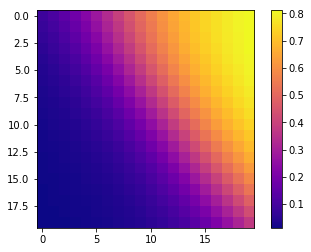

In [18]:
#get 20 values between 0 and 1 for both x and y inputs
x = y = np.linspace(0,1,20)

#make a 20x20 matrix of all zeros
mat_img = np.zeros((20, 20))

for i in range(20):
    for j in range(20):
        #plot the 0th individual in the population's "phenotype"
        mat_img[i,j] = population[0].execute([x[i],y[j]])[0]
        
pyplot.imshow(mat_img, cmap=pyplot.get_cmap("plasma"))
pyplot.colorbar()
pyplot.show()

## This problem is not trivial, and you may have to increase the number of generations to get a good solution. You could also try more creative fitness functions. It IS solvable with one hidden layer and 5 neurons, but it might be easier with more.

#   


#  


# Just to have some fun, I've added this loop that plots a random neural network's output across the range (-5,5). This helps us get an intuition for the complexity of problems that the networks are able to solve.

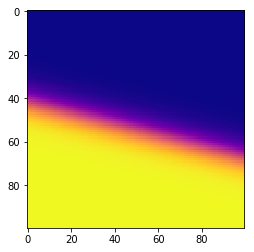

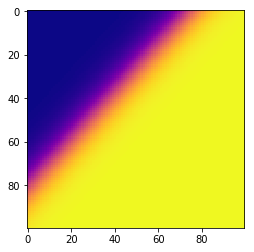

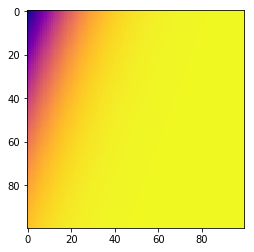

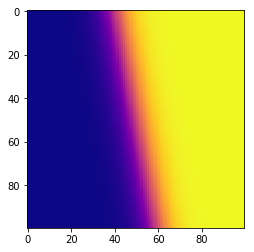

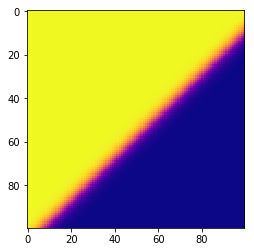

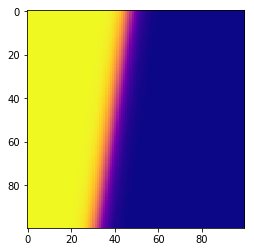

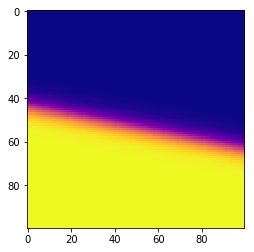

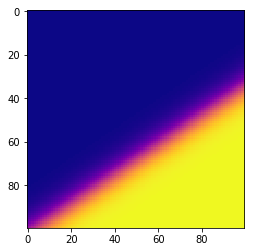

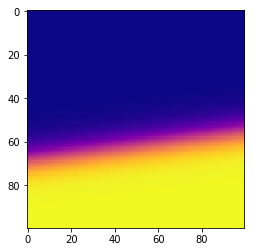

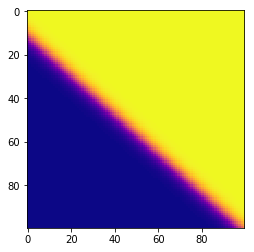

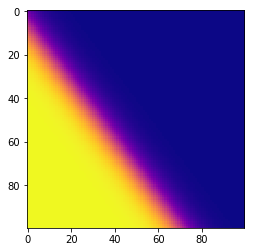

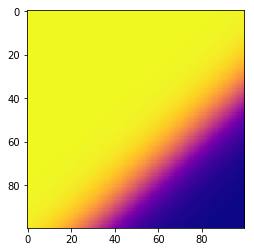

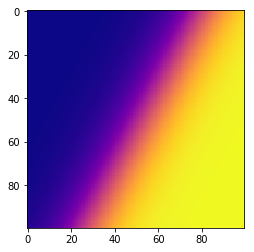

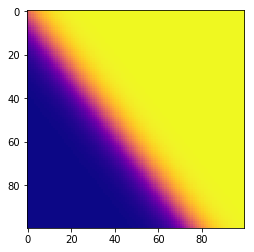

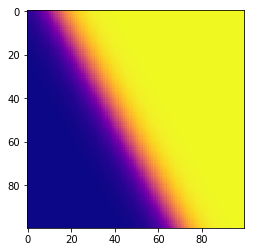

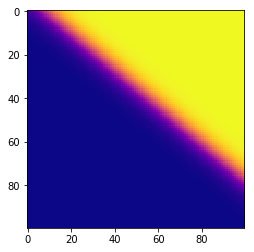

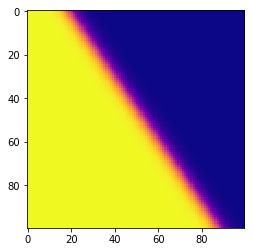

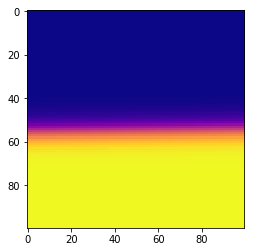

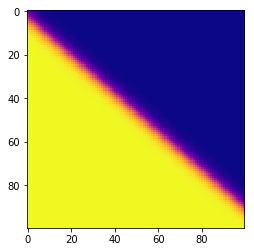

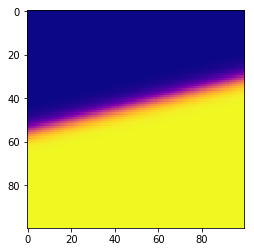

In [7]:
for i in range(20):
    g = SimpleNeuralNet(num_inputs=2, num_outputs=1, layer_node_counts=[])
    #get 20 values between 0 and 1 for both x and y inputs
    x = y = np.linspace(-5,5,100)

    #make a 20x20 matrix of all zeros
    mat_img = np.zeros((100, 100))

    for i in range(100):
        for j in range(100):
            #plot the 0th individual in the population's "phenotype"
            mat_img[i,j] = g.execute([x[i],y[j]])[0]

    pyplot.imshow(mat_img, cmap=pyplot.get_cmap("plasma"))
    pyplot.show()

## Let's add 2 neurons in the hidden layer and see what the random networks look like

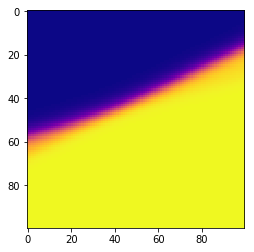

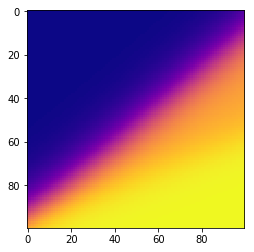

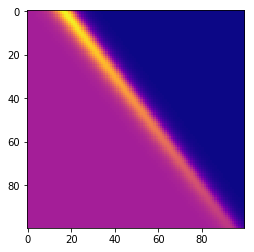

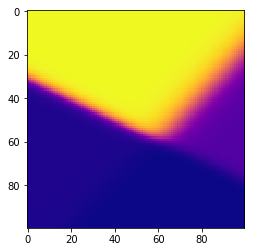

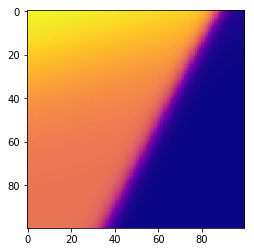

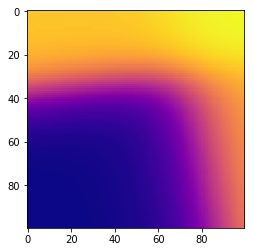

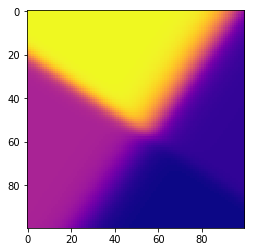

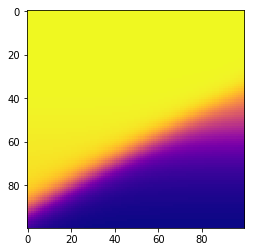

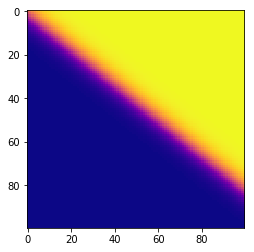

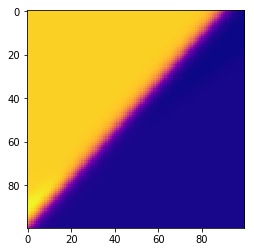

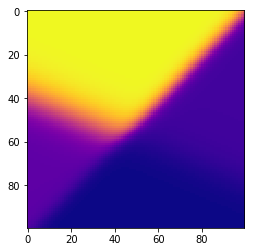

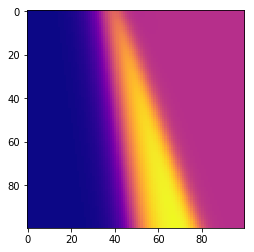

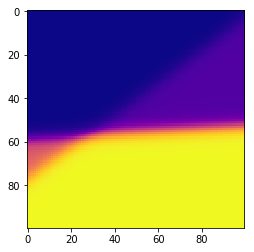

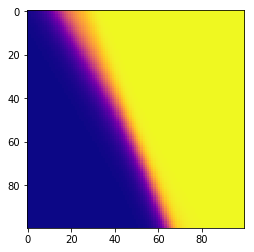

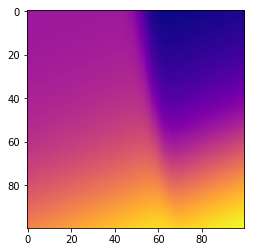

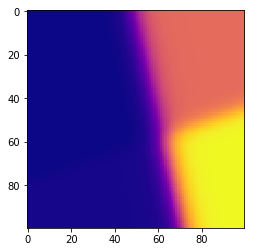

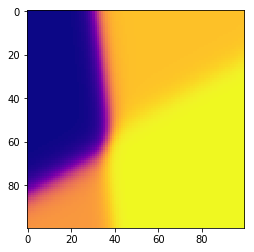

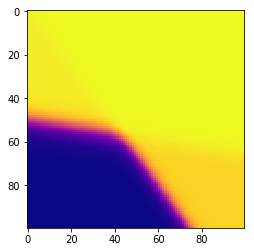

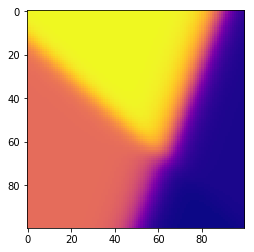

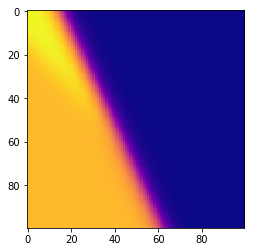

In [8]:
for i in range(20):
    g = SimpleNeuralNet(num_inputs=2, num_outputs=1, layer_node_counts=[2])
    #get 20 values between 0 and 1 for both x and y inputs
    x = y = np.linspace(-5,5,100)

    #make a 20x20 matrix of all zeros
    mat_img = np.zeros((100, 100))

    for i in range(100):
        for j in range(100):
            #plot the 0th individual in the population's "phenotype"
            mat_img[i,j] = g.execute([x[i],y[j]])[0]

    pyplot.imshow(mat_img, cmap=pyplot.get_cmap("plasma"))
    pyplot.show()

## Now what about 10?

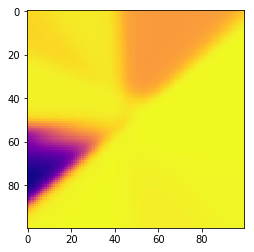

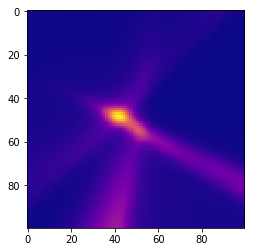

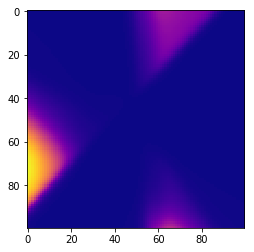

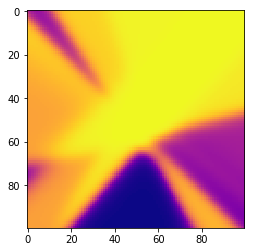

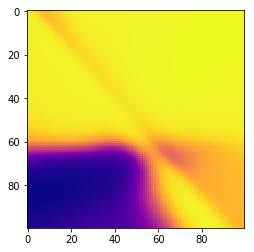

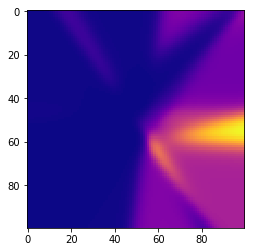

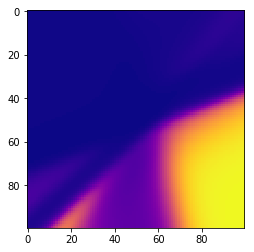

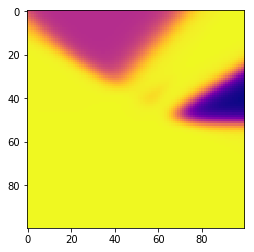

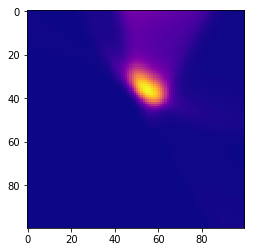

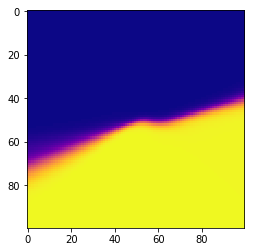

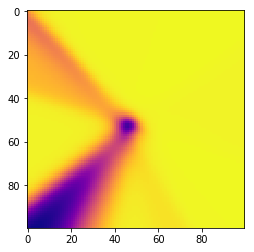

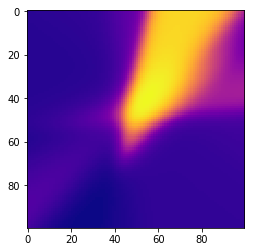

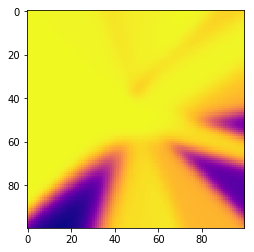

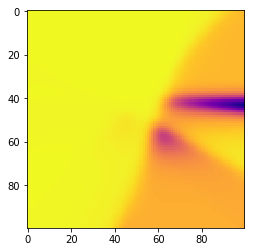

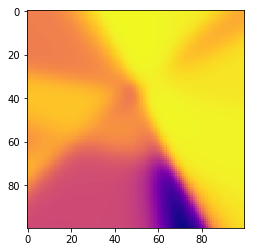

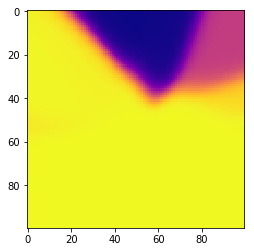

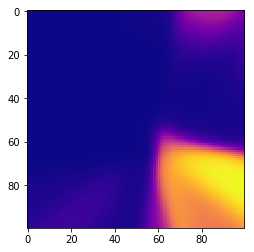

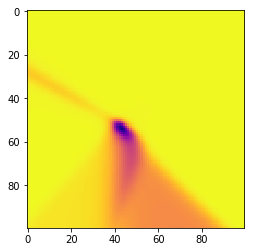

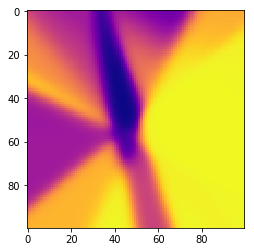

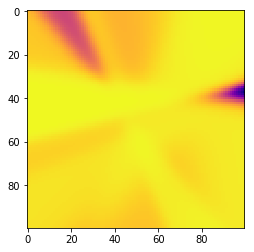

In [19]:
for i in range(20):
    g = SimpleNeuralNet(num_inputs=2, num_outputs=1, layer_node_counts=[10])
    #get 20 values between 0 and 1 for both x and y inputs
    x = y = np.linspace(-5,5,100)

    #make a 20x20 matrix of all zeros
    mat_img = np.zeros((100, 100))

    for i in range(100):
        for j in range(100):
            #plot the 0th individual in the population's "phenotype"
            mat_img[i,j] = g.execute([x[i],y[j]])[0]

    pyplot.imshow(mat_img, cmap=pyplot.get_cmap("plasma"))
    pyplot.show()

## Now what if we have 3 hidden layers, each with 10 neurons?

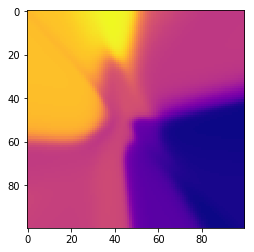

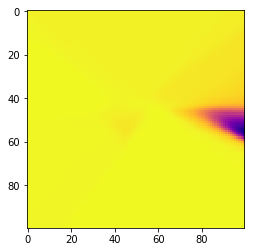

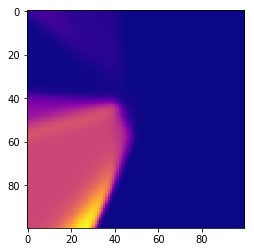

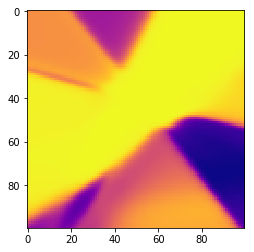

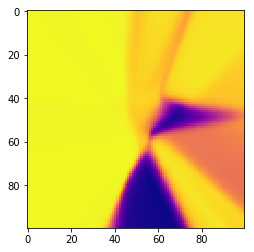

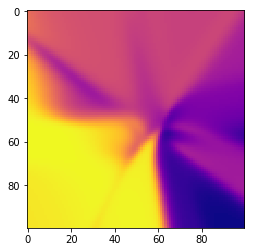

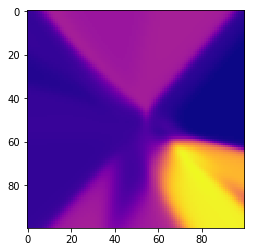

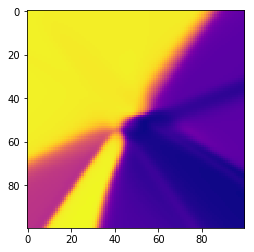

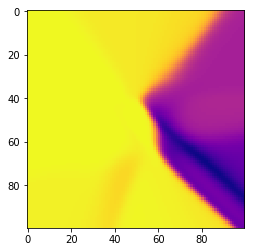

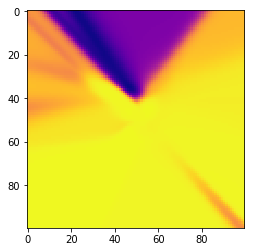

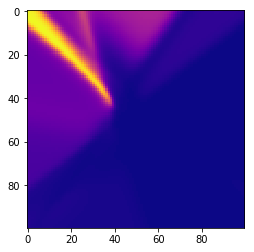

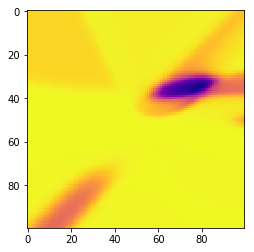

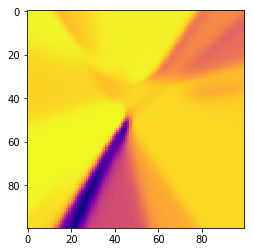

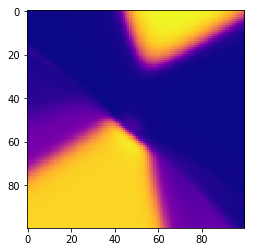

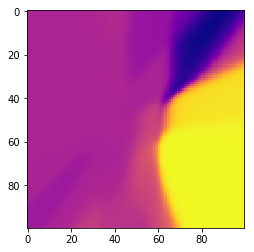

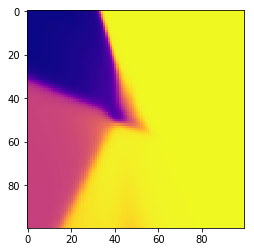

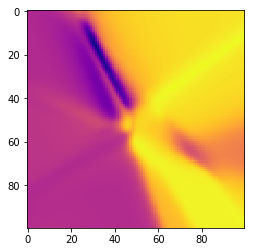

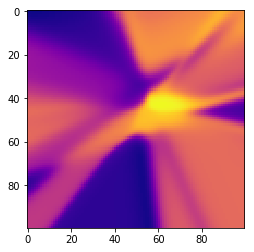

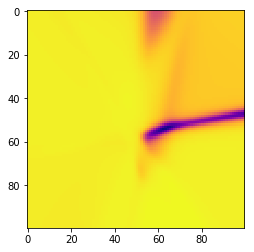

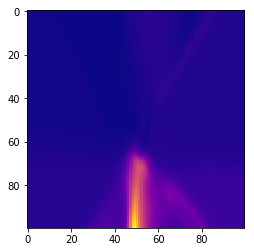

In [20]:
for i in range(20):
    g = SimpleNeuralNet(num_inputs=2, num_outputs=1, layer_node_counts=[10,10,10])
    #get 20 values between 0 and 1 for both x and y inputs
    x = y = np.linspace(-5,5,100)

    #make a 20x20 matrix of all zeros
    mat_img = np.zeros((100, 100))

    for i in range(100):
        for j in range(100):
            #plot the 0th individual in the population's "phenotype"
            mat_img[i,j] = g.execute([x[i],y[j]])[0]

    pyplot.imshow(mat_img, cmap=pyplot.get_cmap("plasma"))
    pyplot.show()